# Clase 4. Preparación de datos. 
## Sección 3. Tratamiento de valores extremos

Este cuaderno contiene los ejemplos en python/SKLearn que acompañan a la [presentación de la clase](../ceia_add_clase5.pdf).

Ejemplos organizados por sección:

- Detección de outliers
    - Método del desvío estándar.
    - Método del rango intercuartil (IQR)
- Tratamiento de outliers
    - Poda
    - 
- Detección y eliminación automática de outliers.

In [6]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pandas:2.0.1
Numpy:1.21.5
Matplotlib:3.5.1
SKlearn:1.0.2
Seaborn:0.11.2



Datasets.

In [7]:
DATASET_PATH="./data"
!ls {DATASET_PATH}

diabetes.csv  diabetes_ex.csv  houseprices.csv	housing_ex.csv	titanic.csv


## 1. Preparación de datos

Carga de datasets utilizados para ejemplos.

Precios de propiedades.

In [8]:
df_houseprice = pd.read_csv(DATASET_PATH+"/houseprices.csv")
df_houseprice.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Titanic.

In [9]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

## 4. Tratamiento de valores extremos (outliers)

- Outliers: valores extremadamente alejados de la distribución de la mayor parte de los datos.
- Identificación y eliminación:
    - Método del desvío estándar
    - Método del rango intercuartil (IQR)
    - Eliminación automática de outliers.

### 4.1 Detección de outliers. Método del desvío estándar ó Z-Score

- Si los datos obedecen una distribución normal:
    - 1STD de la media contendrá el 68% de las muestras
    - 2STD de la media contendrá el 95% de las muestras
    - 3STD de la media contendrán el 99.7% de las muestras.
- Es una práctica común tomar 3STD como valor de corte.

In [11]:
data = 5 * np.random.randn(10000) + 50
data_mean, data_std = np.mean(data), np.std(data)
cutoff = data_std*3
lower,upper = data_mean-cutoff, data_mean+cutoff
outliers_idx = np.argwhere((data<lower) | (data>upper))

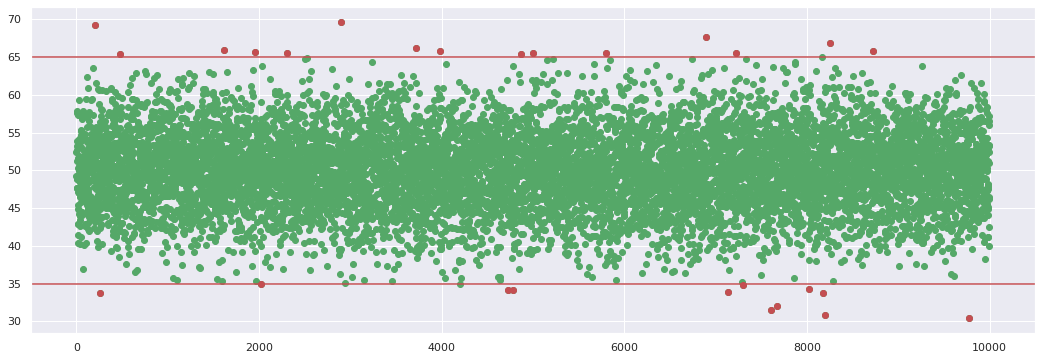

In [12]:
fig,axes = plt.subplots(1,figsize=(18,6))
axes.scatter(np.arange(0,data.shape[0]),data,color='g')
axes.scatter(outliers_idx,data[outliers_idx],color='r')
axes.axhline(lower,color="r");axes.axhline(upper,color="r");

### 4.2 Detección de outliers. Método del rango intercuartil (IQR)

#### El IQR es la diferencia entre el tercer cuartil y el primer cuartil: IQR=Q3−Q1

#### Los outliers se consideran aquellos valores que están fuera del rango de Q1−1.5×IQR (límite inferior) y Q3+1.5×IQR (límite superior).



In [13]:
q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
iqr = q75 - q25
cutoff = iqr * 1.5
lower,upper = q25-cutoff, q75+cutoff
outliers_idx = np.argwhere((data<lower) | (data>upper))

In [21]:
print('valor máximo ',data.max())
print('valor mínimo ',data.min())
print('primer cuartil ',q25)
print('último cuartil ',q75)
print('IQR ',iqr)

valor máximo  69.63118853218162
valor mínimo  30.387998741908287
primer cuartil  46.63704734996449
último cuartil  53.35540443932333
IQR  6.71835708935884


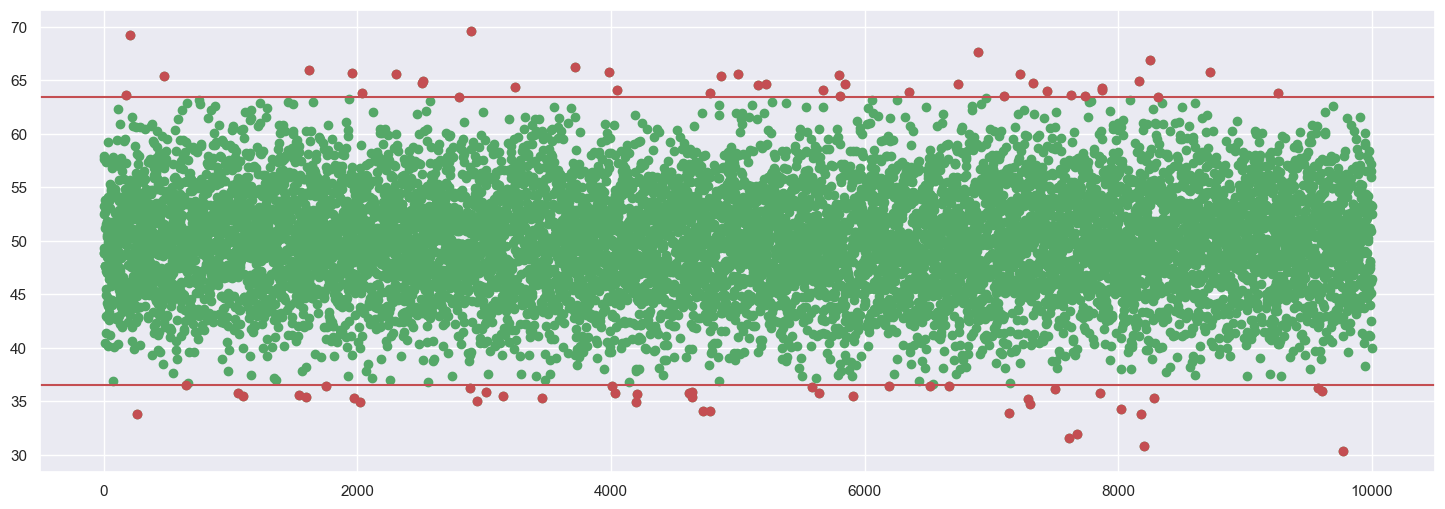

In [9]:
fig,axes = plt.subplots(1,figsize=(18,6))
axes.scatter(np.arange(0,data.shape[0]),data,color='g')
axes.scatter(outliers_idx,data[outliers_idx],color='r')
axes.axhline(lower,color="r");axes.axhline(upper,color="r");

### 4.3 Tratamiento de outliers. Poda (trimming)

Este ejemplo utiliza las funciones de diagnóstico y selección de umbrales introducido en la sección 2 con el dataset de diabetes_df.

En este caso, se eliminarán las muestras que superen los umbrales hallados.

In [53]:
def outlier_diagnostic_plots(df, variable):
    # Filtrar valores NaN en la variable específica y asegurarse que sea numérico
    data = df[variable].dropna().astype(float)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 4))
    
    # Histograma con KDE
    axes[0].hist(data, bins=30, density=True, alpha=0.6, color='g')
    
    # Agregar KDE
    kde = stats.gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    axes[0].plot(x, kde(x), 'k', linewidth=2)
    axes[0].set_title('Histograma con KDE')
    
    
    
    # Boxplot
    axes[1].boxplot(data, vert=False)
    axes[1].set_title('Boxplot')
    
    plt.show()


In [31]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
diabetes_df = pd.DataFrame(diabetes.data,
                      columns= diabetes.feature_names)
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [36]:
data

array([52.48357077, 49.30867849, 53.23844269, ..., 46.47341638,
       52.47882787, 53.22194227])

Estudio de outliers.

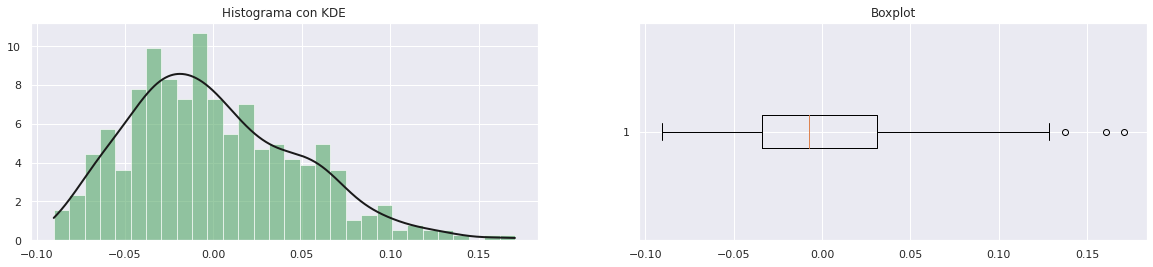

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Reemplazar valores infinitos por NaN en todo el DataFrame
diabetes_df.replace([np.inf, -np.inf], np.nan, inplace=True)



# Llamar a la función
outlier_diagnostic_plots(diabetes_df, 'bmi')


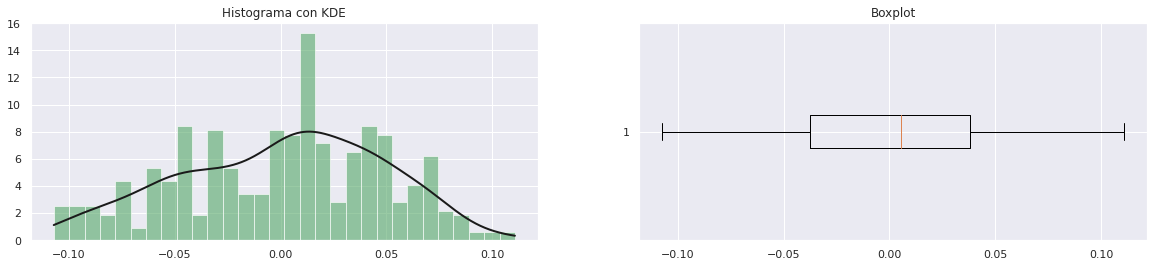

In [55]:
outlier_diagnostic_plots(diabetes_df, 'age')

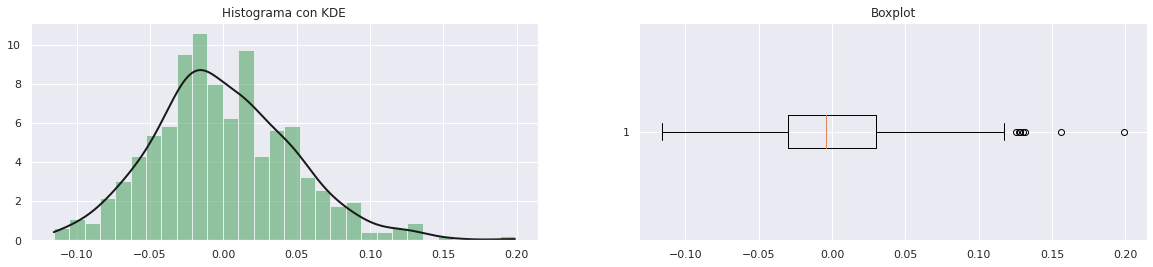

In [56]:
outlier_diagnostic_plots(diabetes_df, 's2')

Como las distribuciones tienen oblicuidad, utilizamos el método de distancia IQR para obtener los umbrales para cada variable.

In [41]:
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [42]:
bmi_upper_limit, bmi_lower_limit = find_skewed_boundaries(diabetes_df, 'bmi', 1.5)
bmi_upper_limit, bmi_lower_limit

(0.12946364066395025, -0.13244469328910888)

In [43]:
age_upper_limit, age_lower_limit = find_skewed_boundaries(diabetes_df, 'age', 1.5)
age_upper_limit, age_lower_limit

(0.1511386657214078, -0.1503620257132154)

In [44]:
s2_upper_limit, s2_lower_limit = find_skewed_boundaries(diabetes_df, 's2', 1.5)
s2_upper_limit, s2_lower_limit

(0.12014858219039615, -0.12066258492575405)

Obtenemos los outliers para cada variable.

In [45]:
outliers_bmi = np.where(diabetes_df['bmi'] > bmi_upper_limit, True,
                       np.where(diabetes_df['bmi'] < bmi_lower_limit, True, False))

In [46]:
outliers_age = np.where(diabetes_df['age'] > age_upper_limit, True,
                       np.where(diabetes_df['age'] < age_lower_limit, True, False))

In [47]:
outliers_s2 = np.where(diabetes_df['s2'] > s2_upper_limit, True,
                       np.where(diabetes_df['s2'] < s2_lower_limit, True, False))

In [68]:
outliers_age.sum()

0

Filtramos los valores que no son outliers y guardamos el resultado en un nuevo dataset.

In [48]:
diabetes_df_trimmed = diabetes_df.loc[~(outliers_bmi + outliers_age + outliers_s2), ]
diabetes_df.shape, diabetes_df_trimmed.shape

((442, 10), (432, 10))

In [49]:
# Porcentaje del dataset original
diabetes_df_trimmed.shape[0]/diabetes_df.shape[0]

0.9773755656108597

Uno de los inconvenientes de esta aproximación, es que se descartaron casi un 2% de los datos originales.

A continuación se estudiarán las distribuciones luego de la poda de outliers.

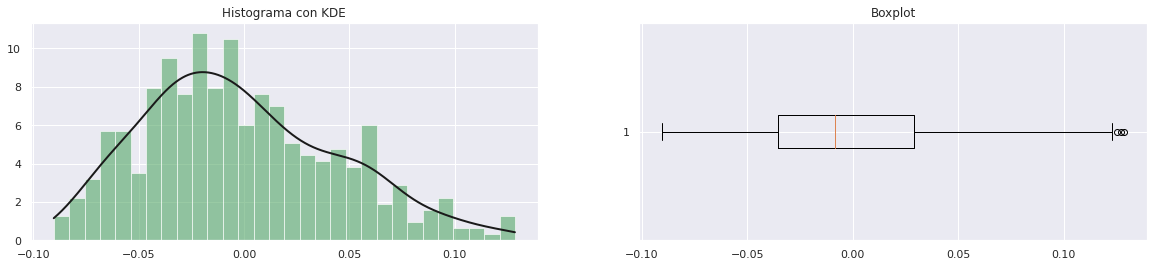

In [57]:
outlier_diagnostic_plots(diabetes_df_trimmed, 'bmi')

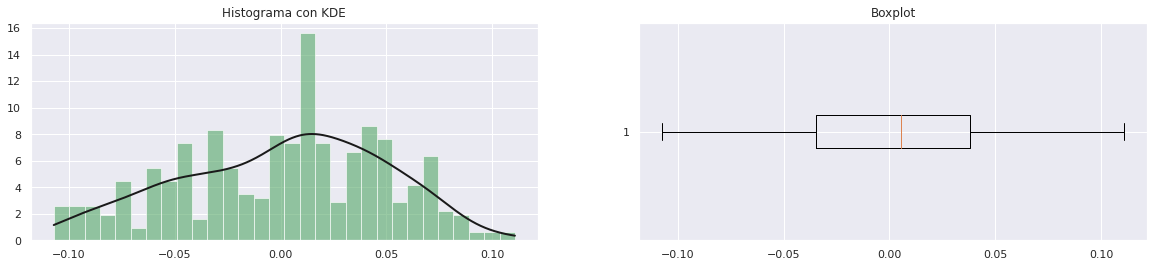

In [58]:
outlier_diagnostic_plots(diabetes_df_trimmed, 'age')

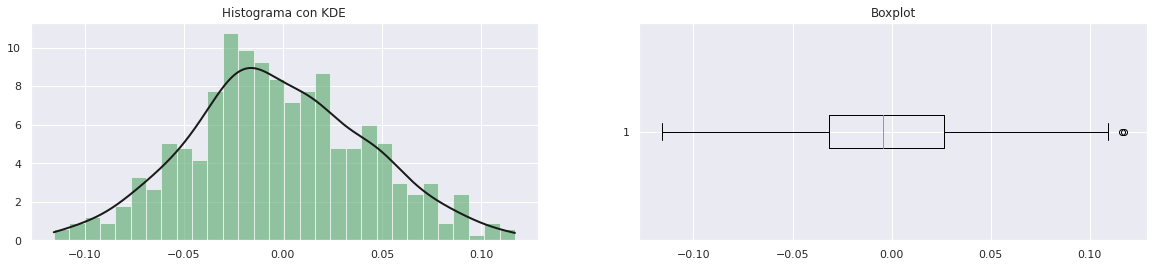

In [59]:
outlier_diagnostic_plots(diabetes_df_trimmed, 's2')

Observaciones:
- En age el resultado es aceptable, la distribución tiene muy pocos valores alejados.
- En bmi y s2, en cambio, valores que antes no eran considerados outliers pasaron a serlo.

### 4.4 Tratamiento de outliers. Censura (capping)

Repetiremos el procedimiento anterior, pero esta vez utilizando censura.

In [60]:
diabetes_df_dataset = load_diabetes()
diabetes_df = pd.DataFrame(diabetes_df_dataset.data,
                      columns=diabetes_df_dataset.feature_names)[[
                          'bmi', 'age', 's2'
                      ]]

In [61]:
diabetes_df['bmi']= np.where(diabetes_df['bmi'] > bmi_upper_limit, bmi_upper_limit,
                       np.where(diabetes_df['bmi'] < bmi_lower_limit, bmi_lower_limit, diabetes_df['bmi']))

In [62]:
diabetes_df['age']= np.where(diabetes_df['age'] > age_upper_limit, age_upper_limit,
                       np.where(diabetes_df['age'] < age_lower_limit, age_lower_limit, diabetes_df['age']))

In [63]:
diabetes_df['s2']= np.where(diabetes_df['s2'] > s2_upper_limit, s2_upper_limit,
                       np.where(diabetes_df['s2'] < s2_lower_limit, s2_lower_limit, diabetes_df['s2']))

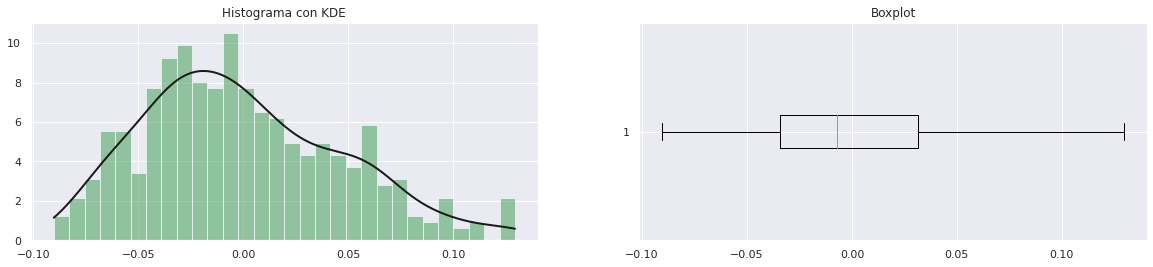

In [64]:
outlier_diagnostic_plots(diabetes_df, 'bmi')

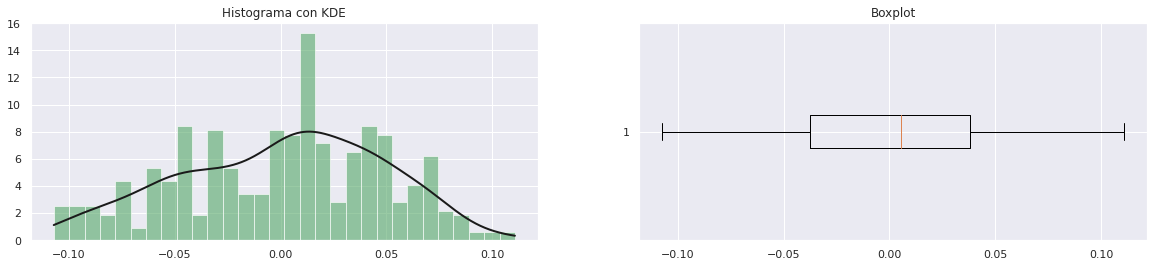

In [65]:
outlier_diagnostic_plots(diabetes_df, 'age')

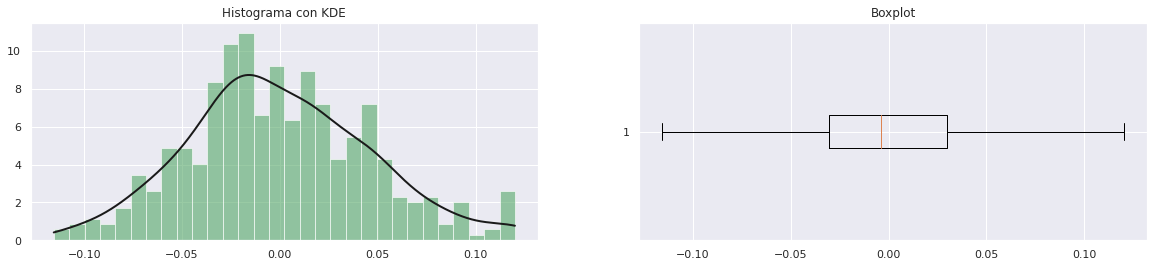

In [66]:
outlier_diagnostic_plots(diabetes_df, 's2')

Observación:
- En este caso desaparecieron los outliers, pero con una distorsión importante de la distribución de bmi y s2.